# Let's Talk Data!
*Final Thinkful Capstone*
*by Kalika Kay Curry*


Marketing. Is. Tough.

Identifying a viable demographic - is no small feat.

Introducing, TalkData!

This project is to construct a product as a working machine learning model that can be used to predict the demographic of the individuals who have participated in this device plan. The plan provides the users' location coordinates, time they accessed the app, phone brand, phone model, applications that they're using, the category those applications belong to, and indicates whether or not the applications are in use.

# Data Preprocessing

The data source consists of seven compressed comma delimited files that has been downloaded from the [TalkData competition](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/overview) on Kaggle. 

The samples pertain to user devices, application ids, event ids, active applications, phone brands and models, categories, and location coordinates. These were downloaded, cleaned, and combined using an iterative process to create a single dataset, for use in exploration.

The processed datasource was then saved to a separate csv file for use in data exploration.

#The datatable name is talkdata
talkdata = training_data.drop(columns=drop_cols)
talkdata.head()

The full process for these data cleaning/preprocessing steps can be observed on the [preprocessing notebook](https://github.com/KalikaKay/TalkData/blob/main/Preprocessing.ipynb). 

# Exploratory Data Analysis

The exploratory data analsyis was conducted using a separate workbook. By separating the analysis from the preprocessing, I was able to focus on the analysis and step away from the preprocessing procedure. This technique also proved beneficial in case of system crashes; a scenario which occured many times, as I attempted to map out all 7 million datapoints a task that crashed my browser several times.

In [58]:
print(f"{time_data.hour.count()} samples were taken over a period of {time_data.index.max() - time_data.index.min()}.\n"
     f"The first sample occured on {time_data.index.min()} and the last sample was taken on {time_data.index.max()}.")

7832282 samples were taken over a period of 7 days 00:07:44.
The first sample occured on 2016-04-30 23:52:24 and the last sample was taken on 2016-05-08 00:00:08.


The sample has a bias toward the male demographic, with most input being taken from men over the age of 32.

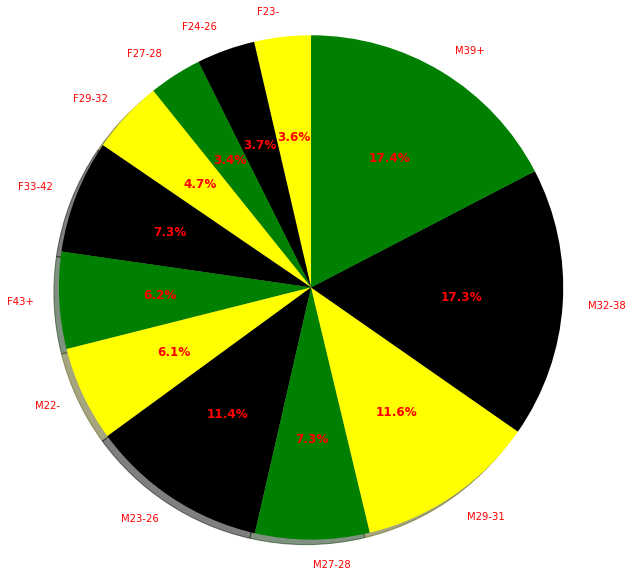

In [42]:
fig1, ax1 = plt.subplots(figsize=(10,10))
labels = list(talkdata.group.value_counts().sort_index().index.values)
wedges, texts, autotexts = ax1.pie(talkdata.group.value_counts().sort_index(), labels=labels, autopct='%1.1f%%',
                          shadow=True, startangle=90, textprops=dict(color="red"), colors=['yellow', 'black', 'green'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.setp(autotexts, size=12, weight="bold")
plt.show()

All users seem to follow the same pattern for device usage. There are peak hours during the middle of the day and low hours in the morning. 

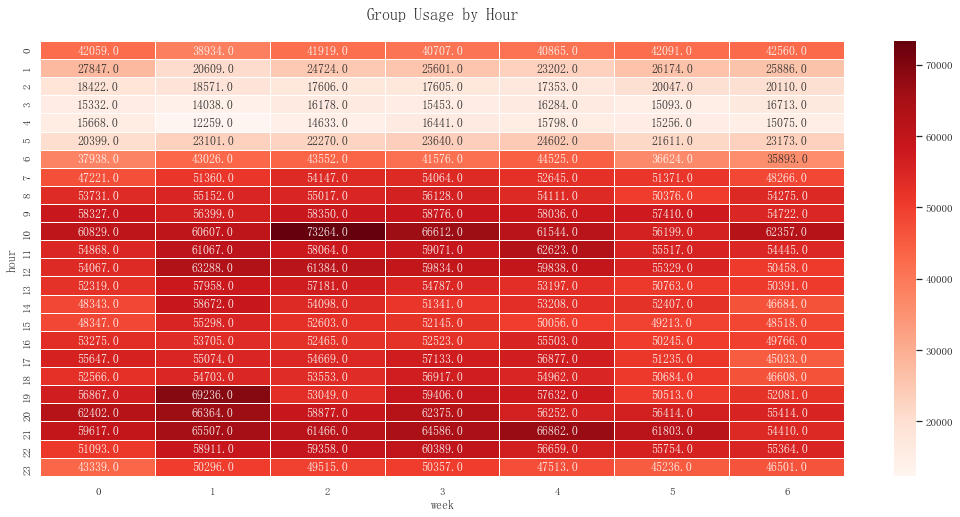

In [253]:
#demographic by time of day. 
heatmap_df = time_data.pivot_table(index='hour', columns='week', values='group', aggfunc='count')
heatmap(heatmap_df, title='Group Usage by Hour')

Overall, these usage rates seem to be similar among all demographics, male; women; and age groups. There are some minor differences; but it does appear to be that they all follow the same pattern for usage.

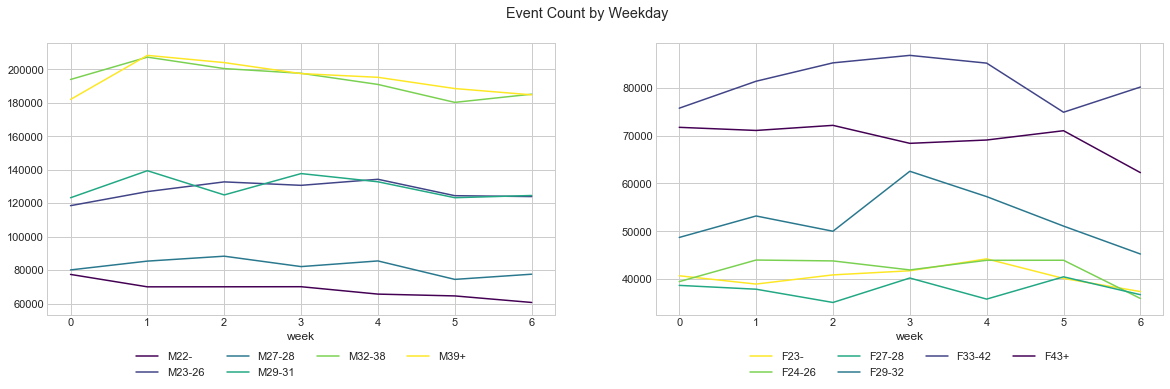

In [330]:
#Demographic by day of week, split by gender.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))

plt.suptitle("Event Count by Weekday")

time_data[time_data.gender == 'M'].pivot_table(index='week', columns='group', values='age', aggfunc='count').plot(ax=ax1, cmap='viridis')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
   
time_data[time_data.gender == 'F'].pivot_table(index='week', columns='group', values='age', aggfunc='count').plot(ax=ax2, cmap='viridis_r')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)

plt.show()

People all over the world are participating, most of them are located in China.

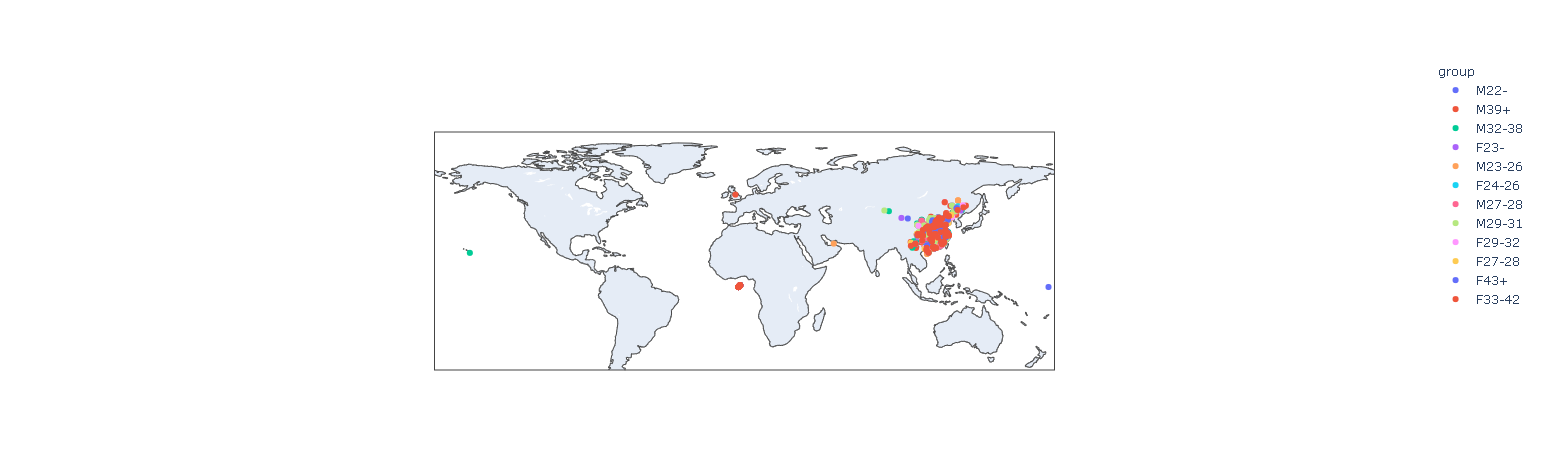

In [14]:
px.scatter_geo(data_frame=map_data, lat='latitude', lon="longitude", scope='world', color='group')

The more detailed explaratory data analysis workbook is available in the [EDA](https://github.com/KalikaKay/TalkData/blob/main/EDA.ipynb) notebook.

# Predictive Analytics 

I downsampled the data, did split the data into train/test sets, and aimed to predict these demographics as were described in the request on Kaggle using a variety of modeling techniques. 

I ran a quick check on using a dummy classification model. The results did not bode well.

Starting with a Dummy classification model and using a one hot encode with a TruncatedSVD (also sometimes known as PCA) reduction method, I see a best score of 0.17 on 120 components. 

In [ ]:
#First run for model selection on 250k records. It takes less than a minute to fit on five estimators. 
pipeline = Pipeline([('enc', OneHotEncoder(handle_unknown='ignore')), 
                     ('svd', TruncatedSVD()),
                     ('dc', DummyClassifier(strategy='most_frequent'))])
params = { 'svd__n_components' :  [120, 12],
          }
#run with verbosity then clear output for readability. 
search = GridSearchCV(pipeline, params, cv=2, verbose=2)
search.fit(X_train, y_train)

In [45]:
print(f"best score: {search.best_score_} \n estimator: {search.best_estimator_}" )

best score: 0.17373197842773752 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('svd', TruncatedSVD(n_components=120)),
                ('dc', DummyClassifier(strategy='most_frequent'))])


Questions reel. Is it my dimensionality reduction technique? Did I conduct the feature analysis wrong? Should I increase the number of features that I'm using? Maybe it's the - demographic. I might need to rebin the age groups, but what do I rebin them to? 

The demographic is a combination of two different characteristics. It is the gender and the age, represented as bin. Can I predict the gender, at least? If I can get a gender, maybe - I can find a way to reveal the ages sometime down the line. 

As demonstrated on the [Model Selection Gender notebook](https://github.com/KalikaKay/TalkData/blob/main/Model%20Selection%20Gender.ipynb), I ran several different models using gridsearch and a variety of parameters. 

I started with a dummy classifer, to determine what the best value to use for two different dimension reduction methods. PCA, which later became TruncatedSVD because PCA would not process against the entirety of the featureset, and SelectKBest.  

## TruncatedSVD (PCA)

In [12]:
#Truncated SVD
pipeline = Pipeline([('enc', OneHotEncoder(handle_unknown='ignore')), 
                     ('svd', TruncatedSVD()),
                     ('dc', DummyClassifier(strategy='most_frequent'))])
params = { 'svd__n_components' :  [50, 75, 60, 10],
          }
#run with verbosity then clear output for readability. 
search = GridSearchCV(pipeline, params, cv=5, verbose=1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('enc',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('svd', TruncatedSVD()),
                                       ('dc',
                                        DummyClassifier(strategy='most_frequent'))]),
             param_grid={'svd__n_components': [50, 75, 60, 10]}, verbose=1)

In [34]:
print(f"best score: {search.best_score_} \n estimator: {search.best_estimator_}" )

best score: 0.7107039290992662 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('svd', TruncatedSVD(n_components=50)),
                ('dc', DummyClassifier(strategy='most_frequent'))])


In [35]:
#an okay score, what's the classification report look like?
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\kalik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           F       0.00      0.00      0.00     45317
           M       0.71      1.00      0.83    111329

    accuracy                           0.71    156646
   macro avg       0.36      0.50      0.42    156646
weighted avg       0.51      0.71      0.59    156646



## SelectKBest


In [ ]:
#First run for model selection on 250k records. It takes less than a minute to fit on five estimators. 
pipeline = Pipeline([('enc', OneHotEncoder(handle_unknown='ignore')), 
                     ('sk', SelectKBest()),
                     ('dc', DummyClassifier(strategy='most_frequent'))])
params = { 'sk__score_func' :  [chi2, f_classif],
           'sk__k' : [100, 90, 95, 110]
          }
#run with verbosity then clear output for readability. 
search = GridSearchCV(pipeline, params, cv=5, verbose=1)
search.fit(X_train, y_train)


In [45]:
print(f"best score: {search.best_score_} \n estimator: {search.best_estimator_}" )

best score: 0.7107039290992662 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('sk',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('dc', DummyClassifier(strategy='most_frequent'))])


In [51]:
#an okay score, what's the classification report look like?
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\kalik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           F       0.00      0.00      0.00     45317
           M       0.71      1.00      0.83    111329

    accuracy                           0.71    156646
   macro avg       0.36      0.50      0.42    156646
weighted avg       0.51      0.71      0.59    156646



## Model Comparison
After getting what can be seen as the best parameter for my dimensionalitiy reduction at least for the basic search, I felt confident searching for the best model. 

Most results were fairly similar, with regards to their accuracy, so I started to search for the model that produced the best accuracy with respect to precision and recall. 

The best model returned was the decision tree, due to its fast processing time with Gradient Boosting working as a good runner up. Most models seemed to perform better with the SelectKBest dimension reduction, which is shown here; with the exception of K Nearest Neighbors, whose results from gridsearch were so poor, that I stopped the kernel and reran with TruncatedSVD.

In [12]:
#Modeling parameters. 
#Some constant variables for parameter settings. 
#cross validation, constant parameter
cv = 5

#multiclass
mc = ['auto', 'ovr', 'multinomial']
#solver
sv = ['newton-cg', 'liblinear', 'sag', 'saga']
#penalty
py = ['l1', 'l2', 'elasticnet', 'none']
#criterion
cn = ['gini', 'entropy']
#max_features
mf = ['auto', None, 'log2']
#splitter
sr = ['best', 'random']
#max_depth
md = [5, 7, 15, 29] 
#n_estimators
ne = [n+50 for n in range(50, 500, 50)]  


#Decompositions models
skb = SelectKBest(k=100, score_func=chi2)
svd =TruncatedSVD(n_components=50)
enc = OneHotEncoder(handle_unknown='ignore')

#logistic regression
lrcPara = { "lrc__multi_class": mc, 
           "lrc__solver": sv,
           #'lrc__penalty' : py       
          }

#decision tree
dtPara = {#'dt__criterion': cn,
           #'dt__max_features': mf,
           #'dt__splitter':sr, 
           'dt__max_depth': md     
          }

#K Nearest Neighbors
knnPara = {'knn__n_neighbors': [3, 9, 39, 12],
           #'knn__weights': ['uniform', 'distance'],
           #'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
           'knn__leaf_size': [30, 12, 9, 3, 17],  
           #'knn__metric': ['mahalanobis','euclidean', 'manhattan', 'chebyshev', 'minkowski', 'seuclidean']   
          }

#Support Vector Classifier
svcPara = {
          'svc__kernel': ['linear', 'rbf'],
          'svc__break_ties': [True] 
          }

#Random Forest Classifier 
rfcPara = {#'rfc__criterion': cn,
           #'rfc__max_features': mf,
           #'rfc__oob_score':[True, False], 
           'rfc__max_depth': md,
           'rfc__n_estimators': ne     
          }

#gradient boost 
gbcPara = {#'gbc__criterion': ['friedman_mse', 'mse', 'mae'],
           #'gbc__max_features': mf,
           'gbc__max_depth': md, 
           'gbc__n_estimators': ne
          }

### Decision Tree

In [ ]:
#SVD
pipeline = Pipeline([('enc', enc), 
                     ('svd', svd),
                     ('dt', DecisionTreeClassifier())])
dt_svd = GridSearchCV(pipeline, dtPara, cv=cv, verbose=3)
dt_svd.fit(X_train, y_train)

In [64]:
roc_auc_score(y_train, dt_svd.predict_proba(X_train)[:, 1])

0.5652984793228599

In [63]:
print(f"best score: {dt_svd.best_score_} \n estimator: {dt_svd.best_estimator_}")

best score: 0.7129877450409752 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('svd', TruncatedSVD(n_components=50)),
                ('dt', DecisionTreeClassifier(max_depth=7))])


In [66]:
#First run for model selection on 250k records. It takes less than a minute to fit on five estimators. 
pipeline = Pipeline([('enc', enc), 
                     ('skb', skb),
                     ('dt', DecisionTreeClassifier())])
dt_skb = GridSearchCV(pipeline, dtPara, cv=cv, verbose=1)
dt_skb.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('enc',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('skb',
                                        SelectKBest(k=100,
                                                    score_func=<function chi2 at 0x00000167ACD188B8>)),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'dt__max_depth': [5, 7, 15, 29]}, verbose=1)

In [67]:
roc_auc_score(y_train, dt_skb.predict_proba(X_train)[:, 1])

0.6043909942677723

In [68]:
print(f"best score: {dt_skb.best_score_} \n estimator: {dt_skb.best_estimator_}")

best score: 0.7350454764480372 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('dt', DecisionTreeClassifier(max_depth=29))])


In [ ]:
#First run for model selection on 250k records. It takes less than a minute to fit on five estimators. 
pipeline = Pipeline([('enc', enc), 
                     ('skb', skb),
                     ('dt', DecisionTreeClassifier())])
para = {
         'dt__max_depth': ne 
        }
dt_skb = GridSearchCV(pipeline, para, cv=cv, verbose=3)
dt_skb.fit(X_train, y_train)

In [76]:
print(roc_auc_score(y_train, dt_skb.predict_proba(X_train)[:, 1]))
print(f"best score: {dt_skb.best_score_} \n estimator: {dt_skb.best_estimator_}")

0.6570450359927795
best score: 0.7484914206628774 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('dt', DecisionTreeClassifier(max_depth=250))])


In [77]:
#Fit and classify on the best score.
y_pred = dt_skb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           F       0.83      0.17      0.28     45317
           M       0.74      0.99      0.85    111329

    accuracy                           0.75    156646
   macro avg       0.79      0.58      0.56    156646
weighted avg       0.77      0.75      0.68    156646



### Gradient Boost

In [ ]:
pipeline = Pipeline([('enc', enc), 
                     ('skb', skb),
                     ('gbc', GradientBoostingClassifier(n_iter_no_change=2))
                    ])

gbc_skb = GridSearchCV(pipeline, gbcPara, cv=cv, verbose=3)
gbc_skb.fit(X_train, y_train)


In [101]:
print_scores(gbc_skb)
class_rep(gbc_skb)

Roc_AUC Score:  0.6570361587017484
best score: 0.7485041882714543 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('gbc',
                 GradientBoostingClassifier(max_depth=29, n_iter_no_change=2))])
              precision    recall  f1-score   support

           F       0.84      0.17      0.28     45317
           M       0.74      0.99      0.85    111329

    accuracy                           0.75    156646
   macro avg       0.79      0.58      0.56    156646
weighted avg       0.77      0.75      0.68    156646



### K Nearest Neighbors

In [ ]:
pipeline = Pipeline([('enc', enc), 
                     ('svd', svd),
                     ('knn', KNeighborsClassifier())
                    ])

knn_svd = GridSearchCV(pipeline, knnPara, cv=cv, verbose=3)
knn_svd.fit(X_train, y_train)


In [168]:
print_scores(knn_svd)

Roc_AUC Score:  0.6456846857386586
best score: 0.7098022131569064 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('svd', TruncatedSVD(n_components=50)),
                ('knn', KNeighborsClassifier(leaf_size=17, n_neighbors=39))])


In [169]:
class_rep(knn_svd)

              precision    recall  f1-score   support

           F       0.48      0.03      0.06     45317
           M       0.71      0.99      0.83    111329

    accuracy                           0.71    156646
   macro avg       0.60      0.51      0.44    156646
weighted avg       0.65      0.71      0.61    156646



# Model Enhancement

After runnning several iterations of models and finding that the decision tree was the best model for predicting the gender on this datasource, I ran through some additional modeling techniques in order to achieve a balanced accuracy. The process can be witnessed in the Performance Enhancing notebook, where I perused a series of imbalance learning models in an attempt to achieve the highest balanced accuracy score. 

As it turns out; the best accuracy that I can achieve with supervised learning models is at 75%, with the following decision tree: 

In [123]:
dt = DecisionTreeClassifier(max_features=2, min_samples_split=12, max_depth=100)
#Classfiication Report, Decision Tree:
class_rep(dt)

              precision    recall  f1-score   support

           F       0.85      0.16      0.27    611778
           M       0.74      0.99      0.85   1502938

    accuracy                           0.75   2114716
   macro avg       0.80      0.57      0.56   2114716
weighted avg       0.78      0.75      0.68   2114716



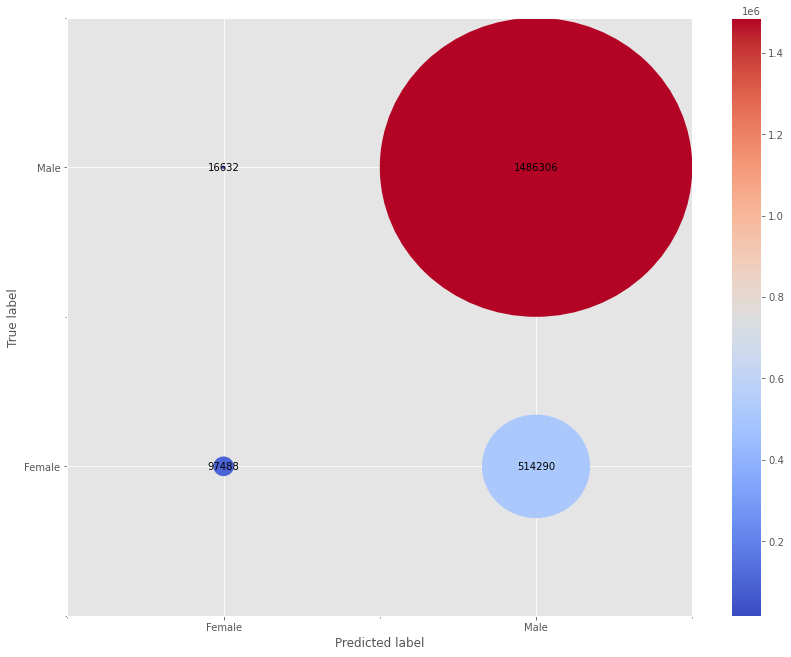

In [124]:
plot_cm(confusion_matrix(y_test, dt.predict(X_test)),['Female','Male'],False, 'tableau-colorblind10')

# Clustering the Model

With a decision tree selected and knowing that I can score an unsuperivsied learning model at 75% accuracy for gender prediction, I began to think about clustering. I immediately started with a KMeans cluster and was not disappointed.

I acheived a silhouette score demsontrating scores well over 70% with the SelectKBest dimension reduction. The results of the gridsearch for the ideal number of clusters can be found at the Model Selection Gender Notebook.

Below is the results of the model selection with a cluster of 20. 

In [142]:
num_clusters = 20
#The test dataset can now be used for evaluating the model. 
X_test, X_prod, y_test, y_prod = train_test_split(X_test, y_test, test_size=0.80, random_state=42, stratify=y_test)

#Encode the data.
enc = OneHotEncoder()
X = enc.fit_transform(X_test)
y = y_test

#Select K Best the data
skb = SelectKBest(k=100, score_func=chi2)
X = skb.fit_transform(X, y)

kmeans = KMeans(n_clusters=num_clusters)
cluster= kmeans.fit_predict(X)
#Run the best silhouette score.
print("scoring the model at: {}".format(datetime.datetime.now()))
print(f'The silhouette score for the {num_clusters} chosen is {silhouette_score(X, cluster)}')
print("Completed scoring the model at: {}".format(datetime.datetime.now()))

scoring the model at: 2021-01-16 21:57:46.735752
The silhouette score for the 20 chosen is 0.8531995262191375
Completed scoring the model at: 2021-01-16 21:57:54.327118


With this model, we can visualize the top five devices preferred by the clustering demographic.

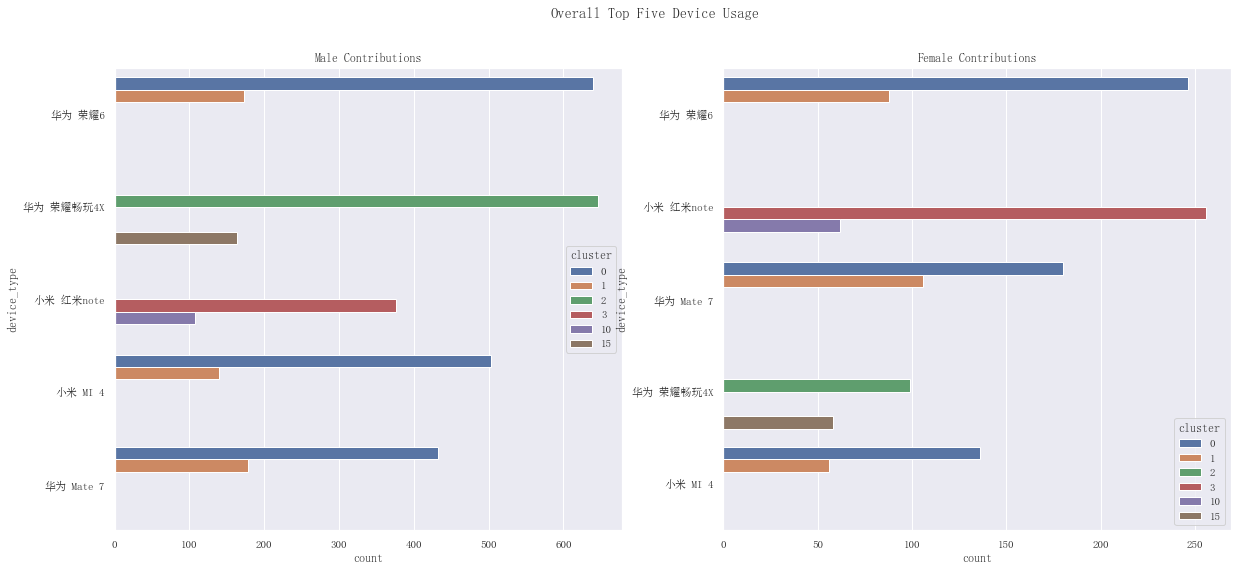

In [30]:

top_five = cluster_model.device_type.value_counts().nlargest(5).keys()
men = cluster_model[cluster_model.gender == 'M']
women = cluster_model[cluster_model.gender == 'F']


men = men[men.device_type.isin(top_five)]
women = women[women.device_type.isin(top_five)]

#Split the count plot.
fig,ax =  plt.subplots(1,2, figsize=(20,8.5))
plt.suptitle('Overall Top Five Device Usage')
sns.countplot(y='device_type', 
            data= men, 
            hue='cluster', 
            ax=ax[0]).set_title('Male Contributions')

sns.countplot(y='device_type', 
            data=women, 
            hue='cluster', 
            ax=ax[1]).set_title("Female Contributions")
plt.show()

With such a demographic, as an application owner, we can identify the devices that are most likely to use our applications; by understanding which demographics are in the cluster model.

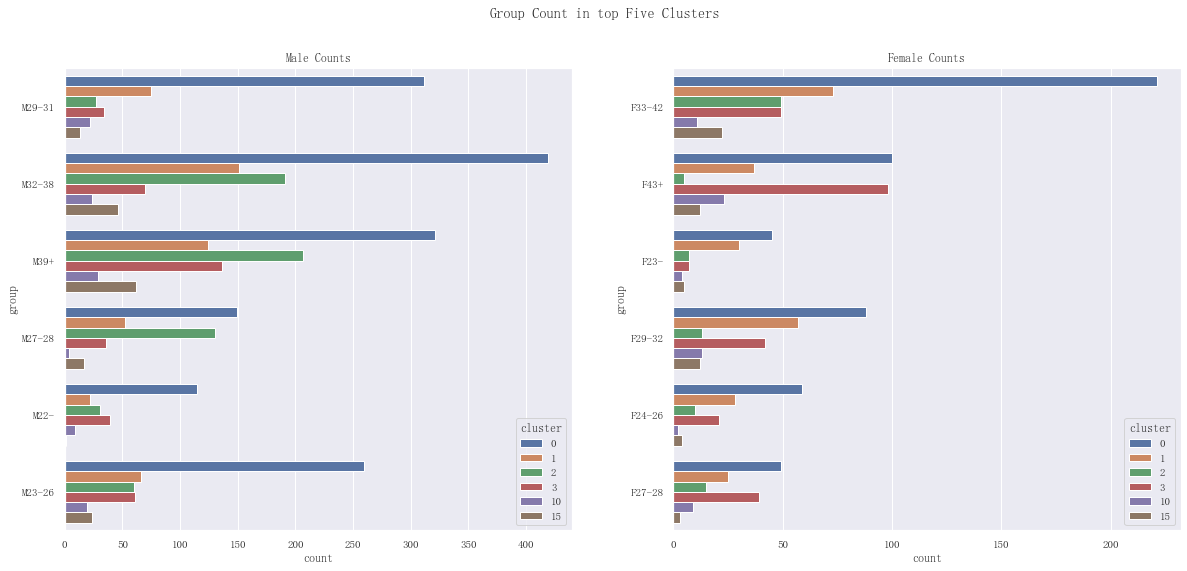

In [184]:
#Split the count plot.
fig,ax =  plt.subplots(1,2, figsize=(20,8.5))
plt.suptitle('Group Count in top Five Clusters')
sns.countplot(y='group', 
            data= men, 
            hue='cluster', 
            ax=ax[0]).set_title('Male Counts')

sns.countplot(y='group', 
            data=women, 
            hue='cluster', 
            ax=ax[1]).set_title("Female Counts")
plt.show()

# Deep Learning

Now that I have an understanding of the demographic, I still have the goal to identify these groups. I cannot discern what information is required to get the age group. I can tell from the cluster selection that, a model will not provide me with the age groups, necessarily. I can look into the actual ages of these individuals, perhaps - and get an age demographic that way. 

Knowing the person's gender might help in this matter and as such; I have got to want to get better results on gender prediction before proceeding with the prediction of the user's ages.

I ran two deep learning models. Detailed information pertaining to the coding sequences and construction of these models can be found on the [Exercise_Deep_Learning_Convolutional](https://github.com/KalikaKay/TalkData/blob/main/Exercise_Deep_Learning_Convolutional.ipynb) and the [Deep_Learning_Gender](https://github.com/KalikaKay/TalkData/blob/main/Deep_Learning_Gender.ipynb) notebooks. 


## Dense Neural Network
The first model was a Dense Neural Network, consisting of features that were engineered using Tensorflow. 

In [61]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
97902/97904 [============================>.] - ETA: 0s - loss: 0.4891 - accuracy: 0.7592WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'timestamp': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=int64>, 'longitude': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'is_active': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'phone_brand': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'device_model': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'category': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functional API.
97904/97904 [==============================] - 1200s 12ms/step - loss: 0.4891 - accuracy: 0.7592 - va

In [62]:
pred=model.predict(test_ds)

Consider rewriting this model with the Functional API.


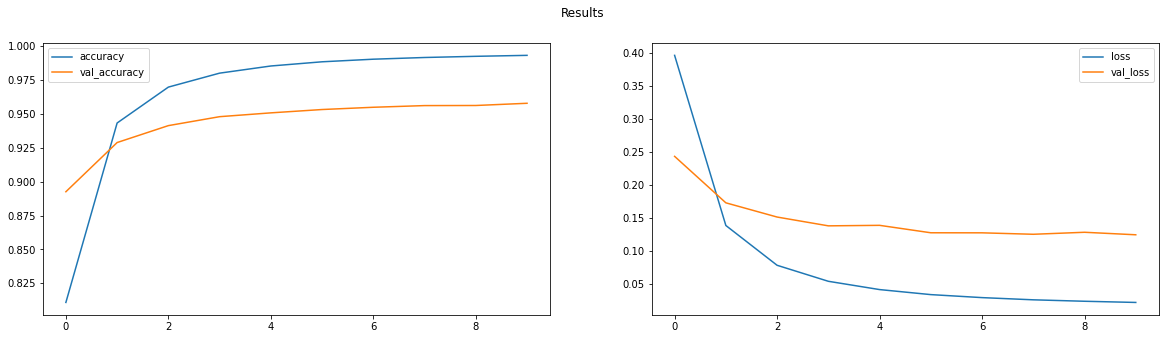

In [69]:
results = pd.DataFrame(history.history)

#Split the count plot.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
results[['accuracy', 'val_accuracy']].plot(ax=ax1)
results[['loss', 'val_loss']].plot(ax=ax2)
plt.show()







In [63]:


#predicted_class_indices=np.argmax(pred,axis=-1) 
predicted_class_indices=(pred > 0.5).astype("int32") #binary class identification.
y_true = test.target

print(classification_report(y_true, 
                            predicted_class_indices))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97   2783809
           1       0.94      0.91      0.93   1132332

    accuracy                           0.96   3916141
   macro avg       0.95      0.95      0.95   3916141
weighted avg       0.96      0.96      0.96   3916141



## Convolutional Neural Network
The second deep learning model is a one dimensional Convolutional Neural Network. 

In [43]:
model = Sequential()

model.add(Conv1D(184, 1, padding='same',
                  input_shape=input_shape))

model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dropout(.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(toyX, toyY, epochs=10, validation_data=(testX, testY))


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6982 - accuracy: 0.3149 - val_loss: 0.6873 - val_accuracy: 0.7006
Epoch 2/10
1/1 [==============================] - 0s 442ms/step - loss: 0.6874 - accuracy: 0.6806 - val_loss: 0.6781 - val_accuracy: 0.7280
Epoch 3/10
1/1 [==============================] - 1s 535ms/step - loss: 0.6782 - accuracy: 0.7219 - val_loss: 0.6698 - val_accuracy: 0.7229
Epoch 4/10
1/1 [==============================] - 1s 504ms/step - loss: 0.6700 - accuracy: 0.7233 - val_loss: 0.6623 - val_accuracy: 0.7183
Epoch 5/10
1/1 [==============================] - 0s 479ms/step - loss: 0.6626 - accuracy: 0.7186 - val_loss: 0.6555 - val_accuracy: 0.7135
Epoch 6/10
1/1 [==============================] - 0s 477ms/step - loss: 0.6558 - accuracy: 0.7153 - val_loss: 0.6493 - val_accuracy: 0.7125
Epoch 7/10
1/1 [==============================] - 0s 448ms/step - loss: 0.6496 - accuracy: 0.7135 - val_loss: 0.6436 - val_accuracy: 0.7118
Epoch 8/10
1/1 [=======

In [44]:
pred=model.predict(testX)
predicted_class_indices=(pred > 0.5).astype("int32") #binary class identification.

In [45]:
print(classification_report(testY.reshape(-1), predicted_class_indices.reshape(-1), zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00    226491
           1       0.71      1.00      0.83    556737

    accuracy                           0.71    783228
   macro avg       0.85      0.50      0.42    783228
weighted avg       0.79      0.71      0.59    783228



The Dense Neural Network with Tensorflow grossly outperformed all models in gender prediction with over 95% accuracy. It allowed for enhanced feature analysis and the process was completed against three million records in minutes, making it the ideal candidate for gender prediction with this dataset.